# Building graphs with Metric Learning

This notebook shows how to build graphs using a metric learning strategy. For this, every hit is independently projected to a latent space using a fully connected neural network. The network is trained to put hits from the same particle close to each other and hits from different particles far from each other. An initial graph can then be constructed by connecting hits that are close in this space.
This strategy has been adapted by ExaTrkx, see for example [section 5.2 here.](https://link.springer.com/10.1140/epjc/s10052-021-09675-8)

This notebook also serves as an introduction to the new pytorch lightning-based framework.

In [1]:
from functools import partial
from pathlib import Path
import os

import torch

from gnn_tracking.training.ml import MLModule
from gnn_tracking.training.tc import TCModule
from gnn_tracking.models.graph_construction import GraphConstructionFCNN
from gnn_tracking.models.graph_construction import NoiseClassifierModel
from gnn_tracking.models.graph_construction import WithNoiseClassification
from gnn_tracking.metrics.losses.metric_learning import GraphConstructionHingeEmbeddingLoss
from pytorch_lightning import Trainer
from gnn_tracking.utils.loading import TrackingDataModule
from gnn_tracking.training.callbacks import ExpandWandbConfig, PrintValidationMetrics
from gnn_tracking.utils.versioning import assert_version_geq
from gnn_tracking.utils.lightning import obj_from_or_to_hparams

from torch_geometric.data import Data
from torch import nn
from pytorch_lightning.core.mixins.hparams_mixin import HyperparametersMixin


assert_version_geq("23.12.0")

## Step 1: Configuring the data

The configuration for train/val/test data and its dataloader is held in the `TrackingDataModule` (subclass of `LightningDataModule`).

In [2]:
# data_dir = Path.cwd().resolve().parent.parent / "test-data" / "data" / "point_clouds" / "v8"
data_path = "/scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v8/"
data_paths = os.listdir(data_path)
data_paths.sort()
data_paths = list(map(lambda x: data_path + x, data_paths))
# assert data_dir.is_dir()

In [3]:
noise_model = NoiseClassifierModel()

In [4]:
dm = TrackingDataModule(
    train=dict(
        dirs=data_paths[1:-1],
    ),
    val=dict(
        dirs=[data_paths[-1]],
        start=0,
        stop=4,
    ),
    identifier="point_clouds_v8"
    # could also configure a 'test' set here
)

Other keys allow to configure the loaders (batch size, number of workers, etc.). See the docstring of `TrackingDataModule` for details.

### Details (for understanding)

Note that all of the following will be done implicitly by the `Trainer` and you won't have to worry about it. But if you want to inspect the data, you can do so.

When calling the `setup` method, the `LightningDataModule` initializes instances of `TrackingDataset` (`torch_geometric.Dataset`) for each of these. We can get the corresponding dataloaders by calling `dm.train_dataloader()` and analog for validation and test.

Example:

In [5]:
# This is called by the Trainer automatically and sets up the datasets
dm.setup(stage="fit")  # 'fit' combines 'train' and 'val'
# Now the datasets are available:
dm.datasets

[10:29:41] INFO: DataLoader will load 7743 graphs (out of 7743 available).
[10:29:41] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v8/part_1/data21000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v8/part_8/data28999_s0.pt
[10:29:41] INFO: DataLoader will load 4 graphs (out of 1000 available).
[10:29:41] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v8/part_9/data29000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v8/part_9/data29003_s0.pt


{'train': TrackingDataset(7743), 'val': TrackingDataset(4)}

In [6]:
# dm.__setitem__('train', noise_model(dm.datasets['train']))

For example, we can inspect the first element of the training dataset:

In [7]:
data = dm.datasets["train"][0]

To get the corresponding dataloaders, use one of the methods (but again, you probalby won't need to):

In [8]:
dm.train_dataloader(), dm.val_dataloader()

(<torch_geometric.loader.dataloader.DataLoader at 0x14cc51ce54d0>,
 <torch_geometric.loader.dataloader.DataLoader at 0x14cc51ce5510>)

## Step 2: Configuring a model

We write a normal `torch.nn.Module`. The easiest way is to import one of the modules that we have already written in the `gnn_tracking` librar.

In [9]:
noise_model = NoiseClassifierModel()
# model = WithNoiseClassification(noise_model,
#                                 GraphConstructionFCNN(in_dim=14, out_dim=8, depth=5, hidden_dim=64))
model = GraphConstructionFCNN(in_dim=14, out_dim=8, depth=5, hidden_dim=64)

In [43]:
# len(dm.datasets['train'])

In [44]:
# dm.datasets['train'][0] = noise_model(dm.datasets['train'][0])

In [10]:
model(data)

{'H': tensor([[-0.0611, -0.2800,  0.2673,  ...,  0.2291, -0.1241, -0.1884],
         [-0.0589, -0.2825,  0.2619,  ...,  0.2286, -0.1228, -0.1877],
         [-0.0572, -0.2842,  0.2582,  ...,  0.2286, -0.1217, -0.1870],
         ...,
         [-0.1896, -0.0706,  0.3904,  ...,  0.5716, -0.0858, -0.1299],
         [-0.1887, -0.0706,  0.3908,  ...,  0.5748, -0.0842, -0.1287],
         [-0.1917, -0.0711,  0.3914,  ...,  0.5701, -0.0842, -0.1321]],
        grad_fn=<MulBackward0>)}

However, you can also write your own. Here is a very simple one:

In [8]:
class DemoGraphConstructionModel(nn.Module, HyperparametersMixin):
    def __init__(
        self,
        in_dim: int,
        hidden_dim: int,
        out_dim: int,
        depth: int = 5,
    ):
        super().__init__()
        # This is made available by the HyperparametersMixin
        # all of our hyperparameters from the __init__ arguments
        # are saved to self.hparams (but we don't need this in this
        # example)
        self.save_hyperparameters()
        assert depth > 2
        _layers = [
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
        ]
        for _ in range(depth - 2):
            _layers.append(nn.Linear(hidden_dim, hidden_dim))
            _layers.append(nn.ReLU())
        _layers.append(nn.Linear(hidden_dim, out_dim))
        self._model = nn.Sequential(*_layers)

    def forward(self, data: Data):
        # Our trainer class will expect us to return a dictionary, where
        # the key H has the transformed latent space.
        return {"H": self._model(data.x)}

Uncomment the next line to use model we just wrote (rather than the default)

In [9]:
# model = DemoGraphConstructionModel(in_dim=14, out_dim=8, hidden_dim=64)

If you are familiar with normal pytorch, there was only few differences:

1. We inherit from `HyperparamsMixin`
2. We call `self.save_hyperparameters()`

### Details (for understanding)

We saved all hyperparameters:

In [13]:
model.hparams

"alpha":      0.6
"depth":      5
"hidden_dim": 64
"in_dim":     14
"out_dim":    8

Note how `depth=5` was saved despite not being specified explicitly (it was recognized as a default parameter).

As always, you can simply evaluate the `model` on a piece of data:

In [14]:
out = model(data)

In [15]:
out["H"][:,1].shape

torch.Size([66114])

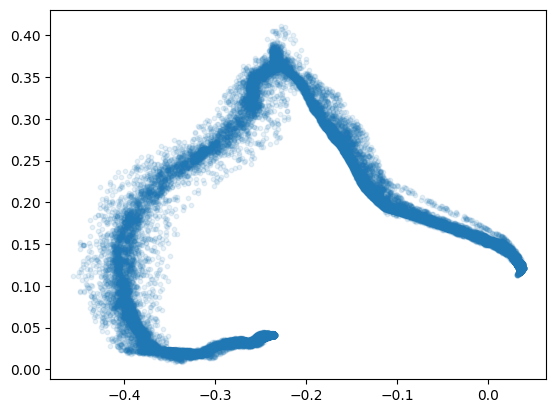

In [38]:
import matplotlib.pyplot as plt

plt.scatter(out["H"][:, 0].detach().numpy(), out["H"][:, 1].detach().numpy(), alpha=0.1, s=10)

## Step 3: Configuring loss functions, metrics and the lightning module

The pytorch model is bundled together with a set of loss functions (just one here), that we backpropagate from in the training step, and a set of metrics. Together, these components make up the `LightningModule` that we pass to the pytorch lightning `Trainer` for training.

If you were familiar with our previous `TCNTrainer` training class, this `MLModule` now fulfills (almost) the exact same role.

In [11]:
lmodel = MLModule(
    model=model,
    loss_fct=GraphConstructionHingeEmbeddingLoss(
        lw_repulsive=0.5,
        max_num_neighbors=10,
    ),
    optimizer=partial(torch.optim.Adam, lr=1e-4),
    preproc=NoiseClassifierModel()
)

### Details (for understanding)

Again, all hyperparameters are accessible (even the ones that weren't explicitly specified but only set by default):

In [47]:
lmodel.hparams

"cluster_scanner": None
"loss_fct":        {'class_path': 'gnn_tracking.metrics.losses.metric_learning.GraphConstructionHingeEmbeddingLoss', 'init_args': {'lw_repulsive': 0.5, 'r_emb': 1.0, 'max_num_neighbors': 10, 'pt_thld': 0.9, 'max_eta': 4.0, 'p_attr': 1.0, 'p_rep': 1.0}}
"model":           {'class_path': 'gnn_tracking.models.graph_construction.GraphConstructionFCNN', 'init_args': {'in_dim': 14, 'hidden_dim': 64, 'out_dim': 8, 'depth': 5, 'alpha': 0.6}}
"preproc":         {'class_path': 'gnn_tracking.models.graph_construction.NoiseClassifierModel', 'init_args': {}}

As you can see, any _objects_ that were passed to the model are also saved to the hyperparameters in a way that we can bring them back.

The loss function takes output from the model and the data and returns two separate losses:

In [48]:
data

Data(x=[66114, 14], edge_index=[2, 229066], y=[0], layer=[66114], particle_id=[66114], pt=[66114], reconstructable=[66114], sector=[66114], eta=[66114], n_hits=[66114], n_layers_hit=[66114])

In [42]:
loss_fct = GraphConstructionHingeEmbeddingLoss()
loss_fct(
    x=out["H"],
    particle_id=data.particle_id,
    batch=data.batch,
    edge_index=data.edge_index,
    pt=data.pt,
    eta=data.eta,
    reconstructable=data.reconstructable,
    true_edge_index=data.edge_index,
    max_num_neighbors=2,
)

RuntimeError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript (most recent call last):
  File "/home/aj2239/gnn_tracking/src/gnn_tracking/metrics/losses/metric_learning.py", line 26, in _hinge_loss_components
    eps = 1e-9

    dists_att = norm(x[att_edges[0]] - x[att_edges[1]], dim=-1)
                     ~~~~~~~~~~~~~~~ <--- HERE
    norm_att = att_edges.shape[1] + eps
    v_att = torch.sum(torch.pow(dists_att, p_attr)) / norm_att
RuntimeError: index 63617 is out of bounds for dimension 0 with size 62352


Both parts of the loss functions are combined with the loss weight we have configured above (weight of 1 for attractive, weight of 0.5 for repulsive). All of this is done in `MLModule.get_losses` (returning the total loss and a dictionary of the individual losses):

In [17]:
lmodel.get_losses(out, data)

(tensor(4.8017, grad_fn=<AddBackward0>),
 {'attractive': tensor(0.0208, grad_fn=<DivBackward1>),
  'repulsive': tensor(9.5617, grad_fn=<DivBackward1>),
  'attractive_weighted': 0.020849432796239853,
  'repulsive_weighted': 4.780872821807861,
  'n_hits_oi': 10506.0,
  'n_edges_att': 37848,
  'n_edges_rep': 100818,
  'total': 4.801722049713135})

## Step 4: Training

In [12]:
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
from wandb_osh.lightning_hooks import TriggerWandbSyncLightningCallback
from gnn_tracking.utils.nomenclature import random_trial_name

name = random_trial_name()

logger = WandbLogger(
    project="gnn_tracking_gc",
    group="pixel-gc",
    offline=True,
    version=name,
    tags=["noise-pixel-gc-test"],
)

tb_logger = TensorBoardLogger(".", version=name)

─────────────────────────── aloof-impossible-boobook ───────────────────────────

In [72]:
trainer = Trainer(
    max_epochs=100,
    accelerator="gpu",
    log_every_n_steps=1,
    callbacks=[PrintValidationMetrics()],
)
trainer.fit(model=lmodel, datamodule=dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[10:25:46] INFO: DataLoader will load 7743 graphs (out of 7743 available).
[10:25:46] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v8/part_1/data21000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v8/part_8/data28999_s0.pt
[10:25:46] INFO: DataLoader will load 4 graphs (out of 1000 available).
[10:25:46] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v8/part_9/data29000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v8/part_9/data29003_s0.pt
/scratch/gpfs/aj2239/micromamba/envs/gnn/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /home/aj2239/aryaman-gnn-tracking-experiments/notebooks/lightning_logs/version_539776

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/scratch/gpfs/aj2239/micromamba/envs/gnn/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/scratch/gpfs/aj2239/micromamba/envs/gnn/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

/scratch/gpfs/aj2239/micromamba/envs/gnn/lib/python3.11/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [ ]:
trainer = Trainer(
    max_epochs=100,
    accelerator="gpu",
    log_every_n_steps=1,
    callbacks=[TriggerWandbSyncLightningCallback(), PrintValidationMetrics()],
    logger=[tb_logger, logger],
)
trainer.fit(model=lmodel, datamodule=dm)

10:30:10 INFO: This is wandb-osh v1.2.0 using communication directory /home/aj2239/.wandb_osh_command_dir
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100 80GB PCIe MIG 1g.10gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING `resume` will be ignored since W&B syncing is set to `offline`. Starting a new run with run id aloof-impossible-boobook.


[10:30:11] INFO: DataLoader will load 7743 graphs (out of 7743 available).
[10:30:11] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v8/part_1/data21000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v8/part_8/data28999_s0.pt
[10:30:11] INFO: DataLoader will load 4 graphs (out of 1000 available).
[10:30:11] DEBUG: First graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v8/part_9/data29000_s0.pt, last graph is /scratch/gpfs/IOJALVO/gnn-tracking/object_condensation/point_clouds_v8/part_9/data29003_s0.pt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-74d68ce8-f74a-5408-a325-06b493f31c14]

  | Name     | Type                                | Params
-----------------------------------------------------------------
0 | model    | GraphConstructionFCNN               | 17.8 K
1 | preproc  | NoiseClassifierModel                | 0     
2 | loss_fct | GraphConstructionHingeEmbeddingLoss | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/scratch/gpfs/aj2239/micromamba/envs/gnn/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/scratch/gpfs/aj2239/micromamba/envs/gnn/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

                Validation epoch=0                 
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━┓
┃ Metric                    ┃       Value ┃ Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━┩
│ attractive                │     3.12842 │   nan │
│ attractive_train          │     3.05097 │   nan │
│ attractive_weighted       │     3.12842 │   nan │
│ attractive_weighted_train │     3.05097 │   nan │
│ n_edges_att               │ 35077.50000 │   nan │
│ n_edges_att_train         │ 32264.00000 │   nan │
│ n_edges_rep               │ 95462.75000 │   nan │
│ n_edges_rep_train         │ 92516.00000 │   nan │
│ n_hits_oi                 │  9646.25000 │   nan │
│ n_hits_oi_train           │  8863.00000 │   nan │
│ repulsive                 │     2.39414 │   nan │
│ repulsive_train           │     2.69031 │   nan │
│ repulsive_weighted        │     1.19707 │   nan │
│ repulsive_weighted_train  │     1.34516 │   nan │
│ total                     │     4.32549 │   nan │
│ total_trai

Validation: |          | 0/? [00:00<?, ?it/s]

                   Validation epoch=1                   
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Metric                    ┃       Value ┃      Error ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ attractive                │     2.89488 │    0.65236 │
│ attractive_train          │     2.80514 │        nan │
│ attractive_weighted       │     2.89488 │    0.65236 │
│ attractive_weighted_train │     2.80514 │        nan │
│ n_edges_att               │ 35077.50000 │  928.13483 │
│ n_edges_att_train         │ 34664.00000 │        nan │
│ n_edges_rep               │ 79278.25000 │ 3821.25806 │
│ n_edges_rep_train         │ 77237.00000 │        nan │
│ n_hits_oi                 │  9646.25000 │  291.88177 │
│ n_hits_oi_train           │  9506.00000 │        nan │
│ repulsive                 │     1.91917 │    0.51111 │
│ repulsive_train           │     1.89004 │        nan │
│ repulsive_weighted        │     0.95958 │    0.25555 │
│ repulsive_weighted_train  │  

### If there are issues with the progress bar

The lightning progress bar can be finnicky when combined with printing the validation results to the command line, especially when running from a Jupyter notebook. Here's a couple of things to try:

* set `enable_progress_bar=False` in the `Trainer` initialization to disable the progress bar
* use `callbacks=[pytorch_lightning.callbacks.RichProgressBar(leave=True), ...]` in the `Trainer` initialization (this is a prettier progress bar, anyway). I
* use `callbacks=[gnn_tracking.utils.lightning.SimpleTqdmProgressBar(leave=True), ...]`
* remove the `PrintValidationMetrics` callback

## Restoring a pre-trained model

Take a look at the `lightning_logs` directory:

In [17]:
! ls lightning_logs

version_53551072  version_53862723  version_53977655


Take the latest version number in the following

In [32]:
! ls lightning_logs/version_2/checkpoints

'epoch=0-step=1.ckpt'


Navigate to one of the versions and take a look at the `hparams.yaml` file. It should contain exactly the hyperparameters from the run.


In [33]:
! cat lightning_logs/version_2/hparams.yaml

model:
  class_path: gnn_tracking.models.graph_construction.GraphConstructionFCNN
  init_args:
    in_dim: 14
    hidden_dim: 64
    out_dim: 8
    depth: 5
    alpha: 0.6
preproc: null
loss_fct:
  class_path: gnn_tracking.metrics.losses.metric_learning.GraphConstructionHingeEmbeddingLoss
  init_args:
    lw_repulsive: 0.5
    r_emb: 1.0
    max_num_neighbors: 10
    pt_thld: 0.9
    max_eta: 4.0
    p_attr: 1.0
    p_rep: 1.0
gc_scanner: null


Similarly, you can check out the `config.yaml` file for additional config values affecting the `Trainer` and other elements of the training process.

We can bring back the trained model by loading one of the checkpoints:

In [34]:
restored_model = MLModule.load_from_checkpoint(
    "lightning_logs/version_2/checkpoints/epoch=0-step=1.ckpt"
)

[15:03:04] DEBUG: Getting class GraphConstructionFCNN from module gnn_tracking.models.graph_construction
[15:03:04] DEBUG: Getting class GraphConstructionHingeEmbeddingLoss from module gnn_tracking.metrics.losses.metric_learning


Note how we didn't have to specify any the hyperparameters again.

However, we can easily change some of them by adding them as additional keyword arguments.

In [36]:
restored_model_modified = MLModule.load_from_checkpoint(
    "lightning_logs/version_2/checkpoints/epoch=0-step=1.ckpt",
    loss_fct=GraphConstructionHingeEmbeddingLoss(lw_repulsive=0.1, max_num_neighbors=5),
)

[15:03:23] DEBUG: Getting class GraphConstructionFCNN from module gnn_tracking.models.graph_construction


Note that you cannot modify the model architecture however (but you could in principle change the `beta` parameter of the residual connections).

## Running all of this from the command line

All of the following can be achieved by running the following command:

```bash
python3 gnn_tracking/trainers/run.py fit --model configs/model.yml --data configs/data.yml  --trainer.accelerator cpu --trainer.accelerator cpu
```

with the data config file

```yaml
train:
  dirs:
    - /path/to/your/dir
  stop: 5
test:
  dirs:
    - /path/to/your/dir
  star: 10
  stop: 15
val:
  dirs:
    - /path/to/your/dir
  start: 5
  stop: 10
identifier: point_clouds_v8
```

and model config file:

```yaml
class_path: gnn_tracking.training.ml.MLModule
init_args:
  model:
    class_path: gnn_tracking.models.graph_construction.GraphConstructionFCNN
    init_args:
      in_dim: 14
      out_dim: 8
      hidden_dim: 512
      depth: 5
  loss_fct:
    class_path: gnn_tracking.metrics.losses.GraphConstructionHingeEmbeddingLoss
    init_args:
      lw_repulsive: 0.5
  optimizer:
    class_path: torch.optim.Adam
    init_args:
      lr: 0.0001
```

To quickly override one of the options, you can simply add them to the command line, e.g., `--model.init_args.loss_fct.init_args.lw_repulsive=0.1` or `--model.model.init_args.depth=6`.

## Advanced: Connecting with Weights & Biases

Weights and Biases (wandb.ai) is a great tool to log all of your runs to. 
It's also very easy to set up in principle by adding a callback to the `Trainer`.

However, first you need to create an account (it's free!). If you collaborate with us, you probably want to reach out to us so that we can add you to our project (and can see each other's runs).

Once you have your account, copy your API key into the file `~/.wandb_api_key` on the server from which you run your ML models.

Because we want to later identify our current trial among other trials (and have an easy-to-remember name), let's first create an identifier:


In [37]:
from gnn_tracking.utils.nomenclature import random_trial_name

In [38]:
name = random_trial_name()

─────────────────────────── demonic-logical-platypus ───────────────────────────


After this, let's set up the logger:

In [ ]:
from pytorch_lightning.loggers import WandbLogger


wandb_logger = WandbLogger(
    project="ml",
    group="first",
    offline=True,  # <-- see notes below
    version=name,
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING `resume` will be ignored since W&B syncing is set to `offline`. Starting a new run with run id godlike-buzzard-of-wonder.


We want to keep our checkpoints locally, so let's also initialize the default logger (which would be replaced by `WandbLogger` if we don't add it manually):

In [ ]:
from pytorch_lightning.loggers import TensorBoardLogger


tb_logger = TensorBoardLogger(".", version=name)

Now we'd have all the places in place, if it weren't for one subtlety: The Princeton compute nodes don't have internet connectivity.
This is also why we set `offline=True` to the `WandbLogger`. But that's not a problem, because we have internet on the head node `della-gpu`
(just not on the compute node). So we can simply run `wandb sync /path/to/run/dir` afterwards.
However, because this is annoying, I wrote a package `wandb-osh` to help with this.

To install it, run:

In [ ]:
! pip3 install wandb-osh

Now let's put everything together: 

In [ ]:
from wandb_osh.lightning_hooks import TriggerWandbSyncLightningCallback


trainer = Trainer(
    max_epochs=3,
    accelerator="cpu",
    log_every_n_steps=1,
    callbacks=[
        TriggerWandbSyncLightningCallback(),
        PrintValidationMetrics(),
    ],
    logger=[
        wandb_logger,
        tb_logger,
    ],
)

To sync your run, simply start the `wandb-osh` command line utility on `della-gpu`.
For more information on how this works, see [here](https://github.com/klieret/wandb-offline-sync-hook).